## Gaussian processes with approximate Bayesian computation and sequential Monte Carlo sampling for the reconstruction of late-time Hubble data

Investigation of kernel selection for the Gaussian process using various cosmological datasets ([2106.08688](https://arxiv.org/abs/2106.08688)). This notebook uses the package ``pyabc`` (https://pyabc.readthedocs.io/en/latest/) for approximate Bayesian computation with sequential Monte-Carlo for model selection. The analysis is separated into two parts. The first one using cosmic chronometers and the second one using the compressed Pantheon samples.

References to the data can be found at the end of the notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile
import scipy.stats as st

import pyabc
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

from pyabc import Distribution, RV
from pyabc import ABCSMC
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.visualization import plot_kde_1d

### 1. KS for cosmic chronometers

We import the cosmic chronometer dataset.

In [2]:
cc_data = np.loadtxt('cc_data.txt')

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

This is visualized below.

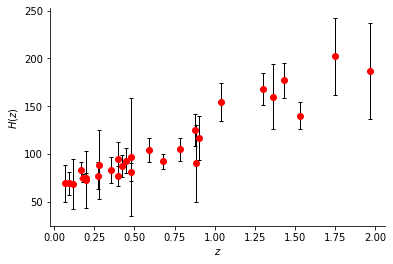

In [3]:
fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'ro', ecolor = 'k',
            elinewidth = 1, capsize = 2)
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
plt.show()

We prepare four kernels below for the analysis: RBF (radial basis function/squared exponential), CHY (Cauchy), and M52 (Matern function index $\nu = 5/2$).

In [4]:
class GP:
    '''Class for making GP predictions.
    
    rbf: k(r) = A^2 \exp(-r^2/(2l^2))
    chy: k(r) = A^2 l^2 / (r^2 + l^2)
    m52: k(r) = A^2 \exp(-\sqrt{5}r/l)
                (1 + \sqrt{5}r/l + 5r^2/(3l^2))
    m72: k(r) = A^2 \exp(-\sqrt{7}r/l)
                (1 + \sqrt{7}r/l + 14r^2/(5l^2)
                   + 7\sqrt{7}r^3/(15l^3))
    
    Input:
    kern = kernel name, i.e., 'rbf', 'chy', 'm52'
    l = length scale
    A = amplitude/height
    '''
    
    def __init__(self, kern, l, A):
        self.length = l
        self.height = A
        self.kern = kern
        
    def kernel(self, x, y):
        if self.kern == 'rbf':
            return (self.height**2)* \
                   np.exp(-((x - y)**2)
                          /(2*self.length**2))
        elif self.kern == 'chy':
            return (self.height**2)* \
                   ((self.length**2)/
                    ((x - y)**2 + self.length**2))
        elif self.kern == 'm52':
            r = x - y
            X = np.sqrt(5)*np.abs(r)/self.length
            B = 1 + X + ((X**2)/3)
            return (self.height**2)*B*np.exp(-X)
        elif self.kern == 'm72':
            r = x - y
            R = np.abs(r)/self.length
            X = np.sqrt(7)*R
            B = 1 + np.sqrt(7)*R + (14*(R**2)/5) \
                + (7*np.sqrt(7)*(R**3)/15)
            return (self.height**2)*B*np.exp(-X)
    
    def k_plus_c_inv(self, Z, C):
        k_ZZ = np.array([[self.kernel(z_i, z_j) \
                          for z_i in Z]
                         for z_j in Z])
        return np.linalg.inv(k_ZZ + C)
    
    def cov(self, Z, C, Zs):
        '''Returns the covariance matrix at Zs.
        
        Note: Zs must be an array.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([[self.kernel(z_i, z_j) \
                          -(self.kernel(z_i, Z) @ \
                            kpc_inv @ \
                            self.kernel(Z, z_j)) \
                          for z_i in Zs] \
                         for z_j in Zs])
    
    def var(self, Z, C, Zs):
        '''Returns the variance at Zs.
        
        Note: Zs must be an array.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([self.kernel(zs, zs) \
                         -(self.kernel(zs, Z) @ \
                           kpc_inv @ \
                           self.kernel(Z, zs)) \
                         for zs in Zs])
    
    def get_logmlike(self, Z, Y, C):
        '''Returns the log-marginal likelihood.'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        kpc = np.linalg.inv(kpc_inv)
        kpc_det = np.linalg.det(kpc)
        Ys = np.array([(self.kernel(zs, Z) @ kpc_inv \
                        @ Y) for zs in Z])
        delta_y = Y
        return -0.5*(delta_y @ kpc_inv @ delta_y) \
               -0.5*np.log(kpc_det) \
               -0.5*len(Z)*np.log(2*np.pi)
    
    def predict(self, Z, Y, C, Zs, with_cov = False, \
                k_as_cov = False):
        kpc_inv = self.k_plus_c_inv(Z, C)
        mean = np.array([(self.kernel(zs, Z) @ kpc_inv \
                          @ Y) for zs in Zs])
        if with_cov == False:
            var_zz = self.var(Z, C, Zs)
            return {'z': Zs, 'Y': mean, \
                    'varY': var_zz}
        elif (with_cov == True) and (k_as_cov == False):
            cov_zz = self.cov(Z, C, Zs)
            return {'z': Zs, 'Y': mean, \
                    'covY': cov_zz}
        elif (with_cov == True) and (k_as_cov == True):
            cov_zz = np.array([[self.kernel(z_i, z_j) \
                                for z_i in Zs] \
                               for z_j in Zs])
            return {'z': Zs, 'Y': mean, \
                    'covY': cov_zz}

We now prepare the input to ``pyabc``.

*Note: In ``pyabc``, the input to the model must be in the form of a dictionary.

In [5]:
class GP_cc:    
    __name__ = 'GP@cc'
        
    def __init__(self, kern, with_cov = False, \
                 k_as_cov = False, \
                 get_lmlk = False):
        self.kern = kern
        self.wcov = with_cov
        self.kcov = k_as_cov
        self.glml = get_lmlk
        
    def __call__(self, par):
        l = par["l"]
        A = par["A"]
        Z = z_cc
        Y = Hz_cc
        C = np.diag(sigHz_cc**2)
        gp = GP(self.kern, l, A)
        gp_dict = gp.predict(Z, Y, C, Z,
                             with_cov = self.wcov,
                             k_as_cov = self.kcov)
        if self.glml == True:
            gp_dict['logmlike'] = gp.get_logmlike(Z, Y, C)
        return gp_dict
    
models = [GP_cc('rbf', True, True),
          GP_cc('chy', True, True),
          GP_cc('m52', True, True),
          GP_cc('m72', True, True)]

Moving forward, to perform ABC-SMC, one must also specify a distance function and prior to the parameters, or in this case, hyperparameters. We consider the log-marginal likelihood as a distance function and a uniform prior for both the length and height hyperparameters.

In [6]:
# observation
obs = {'z': z_cc, 'Y': Hz_cc,
       'varY': sigHz_cc**2,
       'covY': np.diag(sigHz_cc**2)}

# GP's log-marginal likelihood
class logmlike_gp:            
    def __init__(self, N = 0):
        '''N is a positive number bounding
        the log-marginal likelihood from above.'''
        self.N = N
        
    def __call__(self, x, y):
        N = self.N
        delta_y = obs['Y']
        cov_tot = x['covY'] + y['covY']
        inv_cov = np.linalg.inv(cov_tot)
        det_cov = np.linalg.det(cov_tot)
        chi2p = ((delta_y @ inv_cov @ delta_y) \
                 + np.log(det_cov) \
                 + len(obs['z'])*np.log(2*np.pi))
        return abs(-0.5*chi2p - N)

# uniform prior for all kernels
l_min = 0
l_max = 5
A_min = 0
A_max = 200
prior = Distribution(l = RV('uniform', l_min, l_max),
                     A = RV('uniform', A_min, A_max))

priors = [prior, prior, prior, prior]

The ABC-SMC run is prepared below.

In [ ]:
pop_size = AdaptivePopulationSize(100, mean_cv = 0.15,
                                  min_population_size = 50)
abc = ABCSMC(models, priors, logmlike_gp(1e3), \
             population_size = pop_size)

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "ks_cc.db"))

history = abc.new(db_path, obs)

Finally, the ABC-SMC is performed in the next line.

In [ ]:
history = abc.run(minimum_epsilon = 1,
                  max_nr_populations = 10)

We view the results of the kernel selection below.

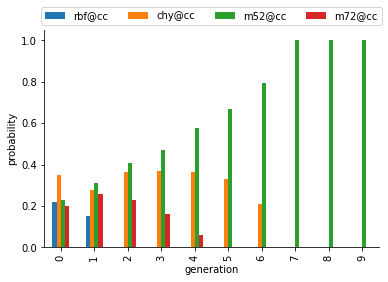

In [12]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("probability");
ax.set_xlabel("generation");
ax.legend(['rbf@cc', 'chy@cc', 'm52@cc', 'm72@cc'], ncol = 4,
          loc = "lower center", bbox_to_anchor = (.5, 1));

The evolution of the posteriors of the hyperparameters can of course be viewed. We first check out the length scale.

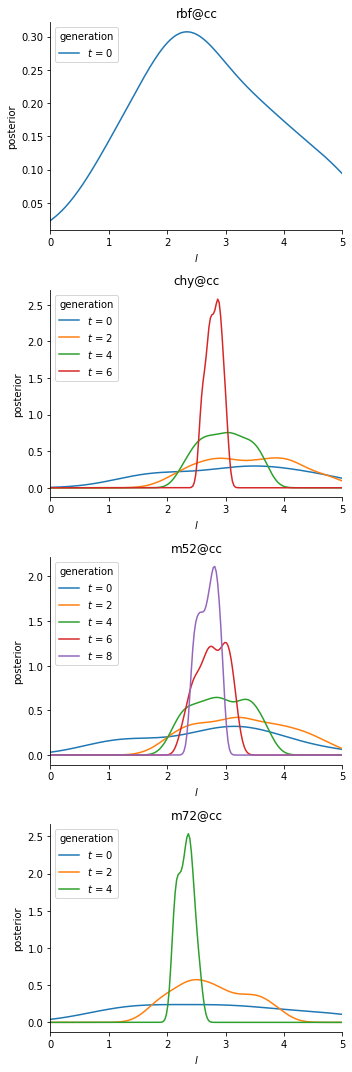

In [13]:
def ax_set(ax, title, xlabel, ylabel, x_min, x_max, \
           legend_title, legend_loc):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(x_min, x_max)
    ax.legend(title = legend_title,
              loc = legend_loc)

fig, axes = plt.subplots(4)
fig.set_size_inches((5, 15))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'l', ax = ax, label = f"$t$ = {t}",
                        xmin = l_min, xmax = l_max, numx = 200)
ax_set(axes[0], 'rbf@cc', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper left')
ax_set(axes[1], 'chy@cc', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper left')
ax_set(axes[2], 'm52@cc', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper left')
ax_set(axes[3], 'm72@cc', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper left')
fig.tight_layout()
plt.show()

For the kernel height, we find the following posterior evolution.

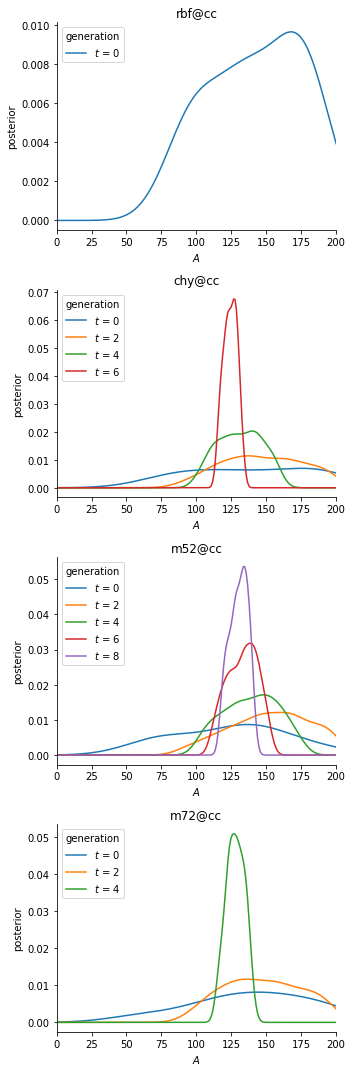

In [14]:
fig, axes = plt.subplots(4)
fig.set_size_inches((5, 15))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 2):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'A', ax = ax, label = f"$t$ = {t}",
                        xmin = A_min, xmax = A_max, numx = 200)
ax_set(axes[0], 'rbf@cc', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper left')
ax_set(axes[1], 'chy@cc', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper left')
ax_set(axes[2], 'm52@cc', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper left')
ax_set(axes[3], 'm72@cc', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper left')
fig.tight_layout()
plt.show()

The predictions of the last surviving population per kernel is shown below.

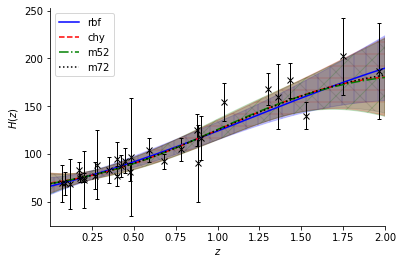

In [15]:
kernels = ['rbf', 'chy', 'm52', 'm72']
last_pop = {}
n_gen = history.n_populations
for m in np.arange(0, len(models)):
    t = n_gen - 1
    df, w = history.get_distribution(m = m, t = t)
    while df.empty == True:
        t -= 1
        df, w = history.get_distribution(m = m, t = t)
    df_arr = df.to_numpy()
    A_abc = np.mean(df_arr[:, 0])
    l_abc = np.mean(df_arr[:, 1])
    last_pop[kernels[m]] = {'df': df, 'w': w,
                            'l': l_abc, 'A': A_abc}

z_min = 1e-5
z_max = 2
n_div = 100
z_rec = np.linspace(z_min, z_max, n_div)

fig, ax = plt.subplots()
clst = ['b', 'r', 'g', 'k']
llst = ['-', '--', '-.', ':']
hlst = ['|', '-', '/', '\\']
alst = [0.2, 0.2, 0.2, 0.1]
for each in last_pop:
    i = kernels.index(each)
    l_abc = last_pop[each]['l']
    A_abc = last_pop[each]['A']
    rec = GP(each, l_abc, A_abc).predict(z_cc, Hz_cc,
                                         np.diag(sigHz_cc**2),
                                         z_rec)
    ax.plot(rec['z'], rec['Y'], clst[i] + llst[i],
            label = each)
    ax.fill_between(rec['z'],
                    rec['Y'] - 2*np.sqrt(rec['varY']),
                    rec['Y'] + 2*np.sqrt(rec['varY']),
                    facecolor = clst[i], alpha = alst[i],
                    hatch = hlst[i], edgecolor = clst[i])
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
             fmt = 'kx', ecolor = 'k',
             elinewidth = 1, capsize = 2)
ax.set_xlabel('$z$')
ax.set_xlim(z_min, z_max)
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left')
plt.show()

Here, it can be seen that the posteriors are visually-indistinguishable. This reveals the selective power of ABC-SMC which singled out the Matern($\nu$ = 5/2) kernel as more special when it comes to fitting the data via GP.

### 2. KS for SNe

Importing the compressed Pantheon dataset.

In [16]:
# load pantheon compressed m(z) data
loc_lcparam = 'lcparam_DS17f.txt'
loc_lcparam_sys = 'sys_DS17f.txt'
lcparam = np.loadtxt(loc_lcparam, usecols = (1, 4, 5))
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# setup pantheon samples
z_ps = lcparam[:, 0]
logz_ps = np.log(z_ps)
mz_ps = lcparam[:, 1]
sigmz_ps = lcparam[:, 2]

# pantheon samples systematics
covmz_ps_sys = lcparam_sys.reshape(40, 40)
covmz_ps_tot = covmz_ps_sys + np.diag(sigmz_ps**2)

We view this data of SNe apparent magnitudes below.

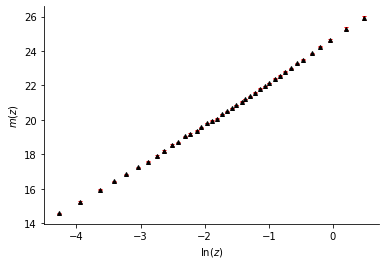

In [17]:
plt.errorbar(logz_ps, mz_ps,
             yerr = np.sqrt(np.diag(covmz_ps_tot)),
             fmt = 'k^', markersize = 4,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$\ln(z)$')
plt.ylabel('$m(z)$')
plt.show()

The models, priors, and distance function to be used as input to $pyabc$ are setup in the next line.

In [18]:
class GP_ps:    
    __name__ = 'GP@ps'
        
    def __init__(self, kern, with_cov = False, \
                 k_as_cov = False, \
                 get_lmlk = False):
        self.kern = kern
        self.wcov = with_cov
        self.kcov = k_as_cov
        self.glml = get_lmlk
        
    def __call__(self, par):
        l = par["l"]
        A = par["A"]
        Z = logz_ps
        Y = mz_ps
        C = covmz_ps_tot
        gp = GP(self.kern, l, A)
        gp_dict = gp.predict(Z, Y, C, Z,
                             with_cov = self.wcov,
                             k_as_cov = self.kcov)
        if self.glml == True:
            gp_dict['logmlike'] = gp.get_logmlike(Z, Y, C)
        return gp_dict
    
models = [GP_ps('rbf', True, True),
          GP_ps('chy', True, True),
          GP_ps('m52', True, True),
          GP_ps('m72', True, True)]

# uniform prior for all kernels
l_min = 0
l_max = 100
A_min = 0
A_max = 200
prior = Distribution(l = RV('uniform', l_min, l_max),
                     A = RV('uniform', A_min, A_max))

priors = [prior, prior, prior, prior]

The ABC-SMC kernel-selection run is prepared below.

In [ ]:
pop_size = AdaptivePopulationSize(700, mean_cv = 0.15,
                                  min_population_size = 300)
abc = ABCSMC(models, priors, logmlike_gp(1e3),
             population_size = pop_size)

obs = {'z': logz_ps, 'Y': mz_ps,
       'covY': covmz_ps_tot}

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "ks_ps.db"))

history = abc.new(db_path, obs)

Finally, the ABC-SMC run is performed.

In [ ]:
history = abc.run(minimum_epsilon = 1,
                  max_nr_populations = 5)

We view the kernel posteriors per generation in the next line.

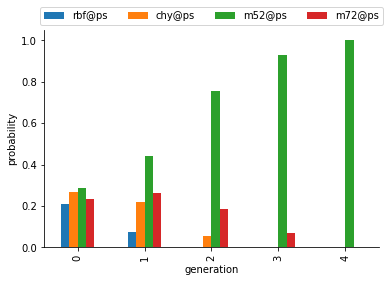

In [20]:
ax = history.get_model_probabilities().plot.bar();
ax.set_ylabel("probability");
ax.set_xlabel("generation");
ax.legend(['rbf@ps', 'chy@ps', 'm52@ps', 'm72@ps'], ncol = 4,
          loc = "lower center", bbox_to_anchor = (.5, 1));

The evolution of the kernel hyperparameters can also be shown. We start by looking at the length scale in the next line.

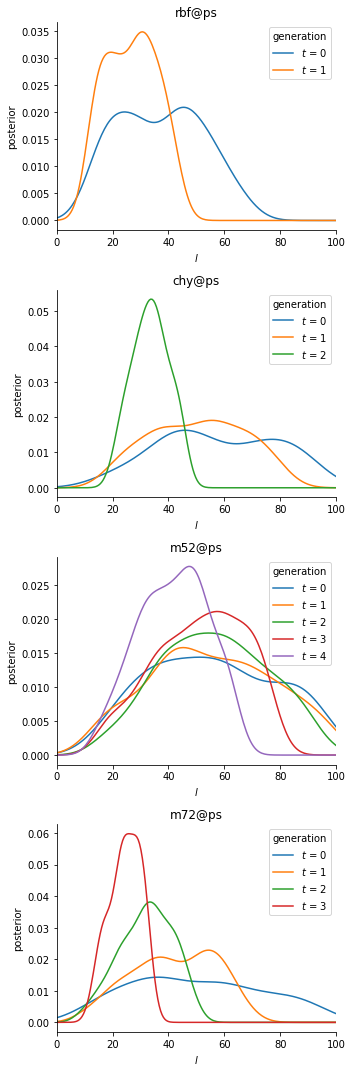

In [21]:
fig, axes = plt.subplots(4)
fig.set_size_inches((5, 15))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 1):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'l', ax = ax, label = f"$t$ = {t}",
                        xmin = l_min, xmax = l_max, numx = 200)
ax_set(axes[0], 'rbf@ps', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper right')
ax_set(axes[1], 'chy@ps', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper right')
ax_set(axes[2], 'm52@ps', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper right')
ax_set(axes[3], 'm72@ps', '$l$', 'posterior',
       l_min, l_max, 'generation', 'upper right')
fig.tight_layout()
plt.show()

Here are the posterior evolution per kernel for the height.

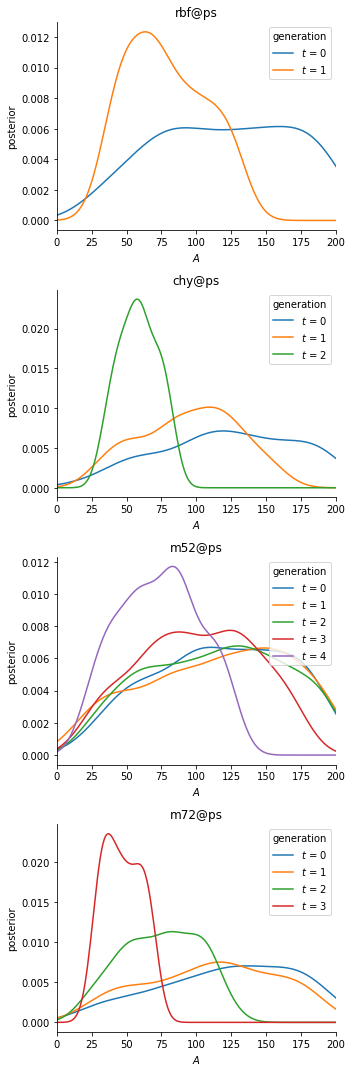

In [22]:
fig, axes = plt.subplots(4)
fig.set_size_inches((5, 15))
axes = axes.flatten()
for m, ax in enumerate(axes):
    for t in range(0, history.n_populations, 1):
        df, w = history.get_distribution(m = m, t = t)
        if len(w) > 0:  # Particles in a model might die out
            plot_kde_1d(df, w, 'A', ax = ax, label = f"$t$ = {t}",
                        xmin = A_min, xmax = A_max, numx = 200)
ax_set(axes[0], 'rbf@ps', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper right')
ax_set(axes[1], 'chy@ps', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper right')
ax_set(axes[2], 'm52@ps', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper right')
ax_set(axes[3], 'm72@ps', '$A$', 'posterior',
       A_min, A_max, 'generation', 'upper right')
fig.tight_layout()
plt.show()

Finally, here is a plot of the prediction of the last surviving population per kernel.

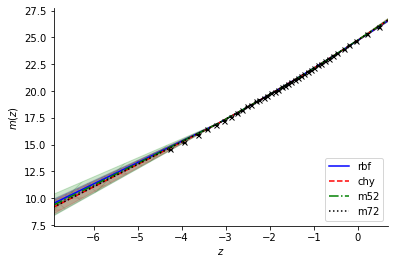

In [23]:
kernels = ['rbf', 'chy', 'm52', 'm72']
last_pop = {}
n_gen = history.n_populations
for m in np.arange(0, len(models)):
    t = n_gen - 1
    df, w = history.get_distribution(m = m, t = t)
    while df.empty == True:
        t -= 1
        df, w = history.get_distribution(m = m, t = t)
    df_arr = df.to_numpy()
    A_abc = np.mean(df_arr[:, 0])
    l_abc = np.mean(df_arr[:, 1])
    last_pop[kernels[m]] = {'df': df, 'w': w,
                            'l': l_abc, 'A': A_abc}

z_min = 1e-3
z_max = 2
n_div = 50
z_rec = np.linspace(z_min, z_max, n_div)
logz_rec = np.log(z_rec)

fig, ax = plt.subplots()
clst = ['b', 'r', 'g', 'k']
llst = ['-', '--', '-.', ':']
hlst = ['|', '-', '/', '\\']
alst = [0.2, 0.2, 0.2, 0.1]
for each in last_pop:
    i = kernels.index(each)
    l_abc = last_pop[each]['l']
    A_abc = last_pop[each]['A']
    rec = GP(each, l_abc, A_abc).predict(logz_ps, mz_ps,
                                         covmz_ps_tot,
                                         logz_rec)
    ax.plot(rec['z'], rec['Y'], clst[i] + llst[i],
            label = each)
    ax.fill_between(rec['z'],
                    rec['Y'] - 2*np.sqrt(abs(rec['varY'])),
                    rec['Y'] + 2*np.sqrt(abs(rec['varY'])),
                    facecolor = clst[i], alpha = alst[i],
                    hatch = hlst[i], edgecolor = clst[i])
ax.errorbar(logz_ps, mz_ps,
            yerr = np.sqrt(np.diag(covmz_ps_tot)),
            fmt = 'kx', markersize = 5,
            ecolor = 'k', elinewidth = 2, capsize = 2)
ax.set_xlabel('$z$')
ax.set_ylabel('$m(z)$')
ax.set_xlim(np.log(z_min), np.log(z_max))
ax.legend(loc = 'lower right')
plt.show()

*$abs$ was used on the RBF results since some of the variances slid to tiny negative numbers ($\sim -10^{-6}$) which should just instead be zero.

### References

***Pantheon***: D. M. Scolnic et al., The Complete Light-curve Sample of Spectroscopically Confirmed SNe Ia
from Pan-STARRS1 and Cosmological Constraints from the Combined Pantheon Sample,
Astrophys. J. 859 (2018) 101 [[1710.00845](https://arxiv.org/abs/1710.00845)].

***Cosmic Chronometers***, from *various sources*:

(1) M. Moresco, L. Pozzetti, A. Cimatti, R. Jimenez, C. Maraston, L. Verde et al., A 6%
measurement of the Hubble parameter at z ∼ 0.45: direct evidence of the epoch of cosmic
re-acceleration, JCAP 05 (2016) 014 [[1601.01701](https://arxiv.org/abs/1601.01701)].

(2) M. Moresco, Raising the bar: new constraints on the Hubble parameter with cosmic
chronometers at z ∼ 2, Mon. Not. Roy. Astron. Soc. 450 (2015) L16 [[1503.01116](https://arxiv.org/abs/1503.01116)].

(3) C. Zhang, H. Zhang, S. Yuan, S. Liu, T.-J. Zhang and Y.-C. Sun, Four new observational H(z)
data from luminous red galaxies in the Sloan Digital Sky Survey data release seven, Research in
Astronomy and Astrophysics 14 (2014) 1221 [[1207.4541](https://arxiv.org/abs/1207.4541)].

(4) D. Stern, R. Jimenez, L. Verde, M. Kamionkowski and S. A. Stanford, Cosmic chronometers:
constraining the equation of state of dark energy. I: H(z) measurements, JCAP 2010 (2010)
008 [[0907.3149](https://arxiv.org/abs/0907.3149)].

(5) M. Moresco et al., Improved constraints on the expansion rate of the Universe up to z ˜1.1 from
the spectroscopic evolution of cosmic chronometers, JCAP 2012 (2012) 006 [[1201.3609](https://arxiv.org/abs/1201.3609)].